# E-commerce — Выявление профилей потребления.

Интернет-магазин товаров для дома «Пока все ещё тут» помогает клиентам обустроить дом своей мечты. 
Задача настоящего проекта — выявление профилей покупателей, а также их сегментация и анализ.


Для решения поставленной задачи будут совершены следующие действия:
1. Проведена подготовка данных, очистка их от дубликатов и аномалий.
2. Проведен исследовательский анализ данных, в частности:
   - Общий анализ представленных данных;
   - Сегментация покупателей на основе истории их покупок;
   - Определение популярных категорий товаров для дома;
   - Проверка сезонности покупки категорий товаров по получившимся кластерам;
3. Составлены и проверены стат. гипотезы для проверки правильности разделения пользователей на кластеры.
4. Построен дашборд и подготовлена презентация по результатам проведенного исследования с выводами и рекомендациями для заказчика.


Датасет, на основе которого будет проводиться исследование, описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут» и имеет следующую структуру:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

### Открытие файла с данными и изучение общей информации.

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gensim
import string
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy import stats as st
import numpy as np
import math as mth
import seaborn as sns
from datetime import datetime

In [2]:
df = pd.read_csv(...)

In [3]:
#выводим общую информацию по ДФ
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


In [4]:
#выводим размеры ДФ
df.shape

(7474, 6)

На первый взгляд, таблица состоит из 6 столбцов и 7474 строк, 3 столбца из которых содержат целые числа, 2 - строчные значения и 1 - числа с плавающей точкой. Также в таблице отсутствуют пропуски.

### Подготовка данных. 

В первую очередь, необходимо преобразовать столбец с датой в надлежащий вид. 

Также хочется столбец с ценой определить в целые числа - с разумной точки зрения, копейки критически не повлияют на выводы по исследованию.

In [5]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%d%H")

In [6]:
df['price'] = df['price'].astype(int)

In [7]:
#проверим ДФ на наличие явных дубликатов
df.duplicated().sum()

0

In [8]:
#проверим ДФ на наличие неявных дубликатов
df.loc[:, df.columns != 'date'].duplicated().sum()

1864

Для того, чтобы найти скрытые дубликаты в датасете, присланном заказчиком, мы сравнили все строки, за исключением даты, так как один заказ мог повторно заноситься в данные на разных этапах его обработки. Таким образом нами найдено 1864 дубликата, которые следует удалить для того, чтобы почистить датасет.

In [9]:
df = df[~(df.loc[:, df.columns != 'date'].duplicated())]

Помимо этого, посмотрим, есть ли заказы, совершенные более, чем одним покупателем.

In [10]:
#составляем список заказов, у которых больше одного покупателя
dup = df.groupby('order_id')['customer_id'].nunique().reset_index()
dup = dup[dup['customer_id'] > 1]

In [11]:
df = df[~df['order_id'].isin(dup['order_id'])]

Теперь перейдем к поиску аномальных значений.

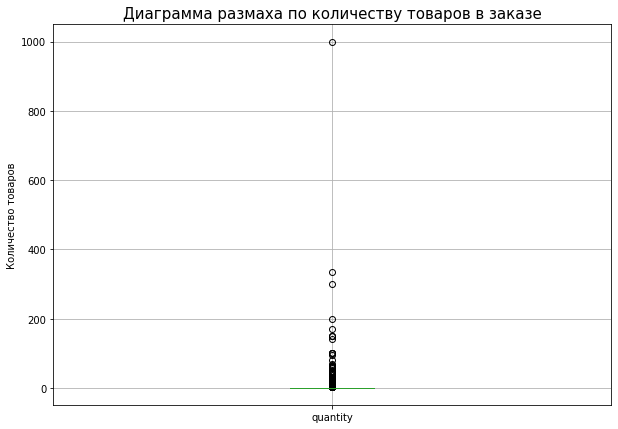

In [12]:
#начнем со столбца quantity
plt.figure(figsize=(10, 7))
df.boxplot(column='quantity')
plt.title('Диаграмма размаха по количеству товаров в заказе', fontsize=15)
plt.ylabel("Количество товаров", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

Согласно полученному графику видно, что большинство заказов находится в диапазоне между 0 и 200 - выглядит вполне логично. Также есть несколько заказов в диапазоне от 200 до 400 - их можно отнести к оптовым. А вот заказ на 1000 выглядит как явный выброс, который в дальнейшем помешает сегментировать профили пользователей корректно. По этой причине удалим только его.

In [13]:
df = df[~(df['quantity'] == 1000)]

Также стоит посмотреть на сумму заказов пользователей.

In [14]:
#для этого создадим дополнительный столбец в нашем датасете
df['total'] = df['quantity'] * df['price']
#создадим табличку с суммами каждого заказа всех пользователей
order_sum = df.groupby(['customer_id', 'order_id'])['total'].sum().reset_index()
order_sum

,customer_id,order_id,total
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,555
1,001cee7f-0b29-4716-b202-0042213ab038,70290,442
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,914
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,1649
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,2324
...,...,...,...
3486,ff601403-b094-4b86-9ac6-264d725b9277,105169,90
3487,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,397
3488,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,69369,389
3489,ffb80538-3fda-4351-8ea9-9d2bec58bb07,72561,974


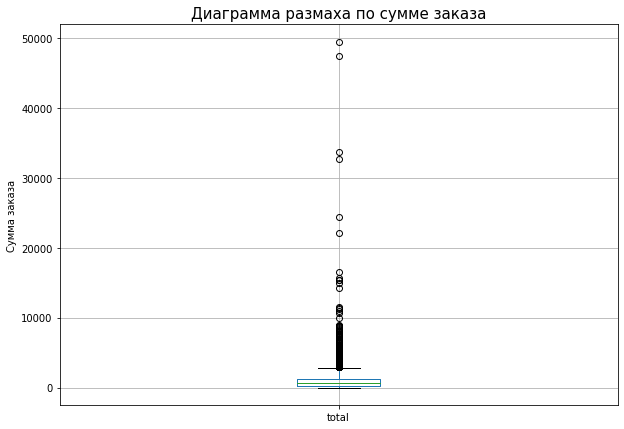

In [15]:
#проанализируем получившийся столбец
plt.figure(figsize=(10, 7))
order_sum.boxplot(column='total')
plt.title('Диаграмма размаха по сумме заказа', fontsize=15)
plt.ylabel("Сумма заказа", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

На основе построенного графика видно, что после 10000 чеки встречаются гораздо реже и единичный заказ достигает отметки в 50000. Посмотрим, сколько данных от начального датафрейма составляют пользователи, чей итоговый чек на заказ превышает 10000.

In [16]:
round(len(df[df['customer_id'].isin(order_sum[order_sum['total'] > 10000]['customer_id'])]) / len(df) * 100, 2)

0.92

Убирать мы их не будем, так как это могут быть оптовые заказчики и их поведение не говорит о какой-либо аномалии в данных. Однако, надо иметь эти данные в виду.

На этом подготовка данных завершена. Теперь можно сбросить индексы и  взглянуть еще раз на полученный датасет, чтобы убедиться, что после удаления дубликатов и аномалий, он продолжает выглядеть адекватно.

In [17]:
df = df.reset_index(drop=True)
df

,date,customer_id,order_id,product,quantity,price,total
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,142
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194,194
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,112
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179,179
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112,112
...,...,...,...,...,...,...,...
5538,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38,76
5539,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869,869
5540,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354,354
5541,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128,128


### Изучение и проверка данных.

**Сколько записей осталось в датафрейме?**

In [18]:
print('Всего в логе', len(df), 'событий.')

Всего в логе 5543 событий.


**Сколько уникальных клиентов есть в датафрейме?**

In [19]:
df['customer_id'].nunique()

2412

**Сколько уникальных заказов есть в датафрейме?**

In [20]:
df['order_id'].nunique()

3491

Итого, в датасете, представленном клиентом, 5607 событий, в которых содержится информация по 2450 уникальным клиентам и 3519 уникальным заказам.

**Сколько заказов приходится на клиента?**

In [21]:
avg_cust = df.groupby(['customer_id', 'order_id'])['product'].count().reset_index()
avg_cust = avg_cust.groupby('customer_id')['order_id'].count().sort_values(ascending=False).reset_index()
avg_cust

,customer_id,order_id
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
4,0184f535-b60a-4914-a982-231e3f615206,5
...,...,...
2407,69cf691b-a6c2-4543-aa8a-8cf42fe4a76e,1
2408,69c524f1-dd2a-4c4e-a5b0-def54dc96f9e,1
2409,69b17a52-a59b-4656-8d47-375e81e7d5f1,1
2410,69897438-1f6c-42f3-8876-ec7f0296072d,1


Итак, в наших данных существует пользователь, который намного чаще пользуется нашим интернет-магазином, чем другие - на сайте было оформлено уже 126 заказов. Конечно, есть пользователи, которые оформили заказ лишь единожды - надеемся, он у них не станет последним))

**Сегментация покупателей на основе истории их покупок.**

Для этой цели будет использоваться метод RFM-анализа и для каждого пользователя определяться давность последнего заказа, частота заказов и общая сумма всех заказов пользователя. После чего по каждому из трех показателей пользователи будут, в свою очередь, сегментированы на группы.

Почти все значения для RFM-анализа нами были получены ранее в ходе подготовки данных, поэтому их сейчас осталось соединить в одну таблицу и переименовать.

In [22]:
#сначала возьмем таблицу с количеством заказов и переименуем нужный столбец
avg_cust = avg_cust.rename(columns={'order_id': 'frequency'})

In [23]:
#теперь таблицу с суммой потраченных денег в магазине для каждого клиента
order_sum = order_sum.groupby('customer_id')['total'].sum().reset_index()
order_sum = order_sum.rename(columns={'total': 'monetary'})

In [24]:
#соединим обе таблицы
df_rfm = avg_cust.merge(order_sum, on='customer_id')
df_rfm

,customer_id,frequency,monetary
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126,159508
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,57278
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,21361
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,3779
4,0184f535-b60a-4914-a982-231e3f615206,5,5891
...,...,...,...
2407,69cf691b-a6c2-4543-aa8a-8cf42fe4a76e,1,3525
2408,69c524f1-dd2a-4c4e-a5b0-def54dc96f9e,1,149
2409,69b17a52-a59b-4656-8d47-375e81e7d5f1,1,1574
2410,69897438-1f6c-42f3-8876-ec7f0296072d,1,1799


In [25]:
#осталось добавить значение recency - как давно покупатель сделал свою последнюю покупку
#создадим табличку с датами последних заказов пользователей
recency = df.groupby('customer_id')['date'].max().reset_index()
#посчитаем, сколько времени прошло с последнего заказа
recency['recency'] = df['date'].max() - recency['date']
recency['recency'] = recency['recency'].apply(lambda td: td.days)
#оформим все в итоговую таблицу
df_rfm_f = df_rfm.merge(recency, on='customer_id')
df_rfm_f = df_rfm_f.drop('date', axis=1)
df_rfm_f

,customer_id,frequency,monetary,recency
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126,159508,331
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,57278,464
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,21361,92
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,3779,282
4,0184f535-b60a-4914-a982-231e3f615206,5,5891,253
...,...,...,...,...
2407,69cf691b-a6c2-4543-aa8a-8cf42fe4a76e,1,3525,335
2408,69c524f1-dd2a-4c4e-a5b0-def54dc96f9e,1,149,103
2409,69b17a52-a59b-4656-8d47-375e81e7d5f1,1,1574,276
2410,69897438-1f6c-42f3-8876-ec7f0296072d,1,1799,312


Следующим шагом будет присвоение каждому пользователю по каждому из определенных критериев оценки от 1 до 4, где 1 - пользователь, который потратил мало денег/давно покупал/покупает редко, а 4 - потратил много денег/покупал недавно/покупает часто.

In [26]:
#формула для недавних пользователей инверсивна по той причине, что наивысшую оценку получит тот пользователь,
#чье значение recency было наименьшим
df_rfm_f['r'] = 5 - (pd.qcut(df_rfm_f['recency'], 4, labels=False) + 1)
#df_rfm_f['f'] = pd.qcut(df_rfm_f['frequency'], 4, labels=False) + 1

In [27]:
#для столбца frequency вручную напишем функцию, так как разбить на 4 одинаковых группы данные невозможно - 
#в данных больше половины пользователей оформляли заказ лишь раз
def get_f(x):
    if x == 1:
        return 1
    if x == 2:
        return 2
    if x == 3:
        return 3
    return 4

df_rfm_f['f'] = df_rfm_f['frequency'].apply(get_f)

In [28]:
#и последний столбец
df_rfm_f['m'] = pd.qcut(df_rfm_f['monetary'], 4, labels=False) + 1

In [29]:
#теперь закончим оформление таблицы итоговым rfm значением, ради которого все это делалось
df_rfm_f['rfm_score'] = df_rfm_f[['r','f','m']].sum(axis=1)

In [30]:
#выводим получившуюся таблицу
df_rfm_f

,customer_id,frequency,monetary,recency,r,f,m,rfm_score
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126,159508,331,2,4,4,10
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,57278,464,1,4,4,9
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,21361,92,3,4,4,11
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,3779,282,2,4,4,10
4,0184f535-b60a-4914-a982-231e3f615206,5,5891,253,2,4,4,10
...,...,...,...,...,...,...,...,...
2407,69cf691b-a6c2-4543-aa8a-8cf42fe4a76e,1,3525,335,2,1,4,7
2408,69c524f1-dd2a-4c4e-a5b0-def54dc96f9e,1,149,103,3,1,1,5
2409,69b17a52-a59b-4656-8d47-375e81e7d5f1,1,1574,276,2,1,3,6
2410,69897438-1f6c-42f3-8876-ec7f0296072d,1,1799,312,2,1,3,6


In [31]:
#осталось сегментировать всех пользователей в соответствии с их rfm_score
def rfm_level(df_rfm_f):
    if df_rfm_f['rfm_score'] >= 9:
        return 'Нельзя терять'
    elif ((df_rfm_f['rfm_score'] >= 8) and (df_rfm_f['rfm_score'] < 9)):
        return 'Чемпион'
    elif ((df_rfm_f['rfm_score'] >= 7) and (df_rfm_f['rfm_score'] < 8)):
        return 'Лояльный'
    elif ((df_rfm_f['rfm_score'] >= 6) and (df_rfm_f['rfm_score'] < 7)):
        return 'Потенциально лояльный'
    elif ((df_rfm_f['rfm_score'] >= 5) and (df_rfm_f['rfm_score'] < 6)):
        return 'Многообещающий'
    elif ((df_rfm_f['rfm_score'] >= 4) and (df_rfm_f['rfm_score'] < 5)):
        return 'Требует внимания'
    else:
        return 'Требует активных действий'

df_rfm_f['client_level'] = df_rfm_f.apply(rfm_level, axis=1)

df_rfm_f.head()

,customer_id,frequency,monetary,recency,r,f,m,rfm_score,client_level
0,c971fb21-d54c-4134-938f-16b62ee86d3b,126,159508,331,2,4,4,10,Нельзя терять
1,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,57278,464,1,4,4,9,Нельзя терять
2,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17,21361,92,3,4,4,11,Нельзя терять
3,b7b865ab-0735-407f-8d0c-31f74d2806cc,7,3779,282,2,4,4,10,Нельзя терять
4,0184f535-b60a-4914-a982-231e3f615206,5,5891,253,2,4,4,10,Нельзя терять


In [32]:
#присоединим получившийся столбец с присвоенным rfm-уровнем пользователей к нашему первоначальному датасету
df = df.merge(df_rfm_f, on='customer_id')
df = df.drop(['frequency', 'monetary', 'recency', 'r', 'f', 'm', 'rfm_score'], axis=1)
df.head()

,date,customer_id,order_id,product,quantity,price,total,client_level
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142,142,Многообещающий
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194,194,Многообещающий
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112,112,Многообещающий
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179,179,Многообещающий
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112,112,Многообещающий


In [33]:
#сделаем сводную таблицу, чтобы оценить общее состояние бизнеса и проделанную работу
rfm_level_agg = df_rfm_f.groupby('client_level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'rfm_score': 'count'
}).round(1).reset_index()

rfm_level_agg = rfm_level_agg.rename(
    columns={
        'client_level': 'категория ',
        'recency': 'кол-во дней с последней покупки',
        'frequency': 'кол-во покупок',
        'monetary': 'кол-во денег',
        'rfm_score': 'кол-во пользователей'
    }
)

rfm_level_agg.sort_values(by='кол-во дней с последней покупки').reset_index(drop=True)

,категория,кол-во дней с последней покупки,кол-во покупок,кол-во денег,кол-во пользователей
0,Нельзя терять,50.4,2.4,3401.1,428
1,Чемпион,100.8,1.8,1889.4,287
2,Лояльный,156.5,1.5,1838.2,362
3,Потенциально лояльный,276.2,1.1,1908.6,420
4,Многообещающий,283.4,1.0,668.0,464
5,Требует внимания,342.7,1.0,393.7,301
6,Требует активных действий,407.5,1.0,218.9,150


Итого, на данном этапе, все пользователи датасета разделены по 3 критериям на 7 категорий в зависимости от количества дней, прошедших с последней покупки, количества совершенных покупок и количества потраченных в нашем интернет-магазине.

На основе полученных сведений можно сегментировать пользователей следующими способами:
   - Активные пользователи и пользователи, которые давно не оформляли заказ.
   - Постоянные пользователи или оформившие один-два заказа.
   - Пользователи, потратившие большую сумму на покупки в интернет-магазине и потратившие маленькую.

**Определить популярные категории товаров для дома.**

Для того, чтобы определить популярные категории, для начала следует, все товары на эти категории разбить.
Мы будем действовать по следующему алгоритму:
1. Убираем все знаки препинания 
2. Лемантизируем: проводим каждое слово к начальной форме + все к нижнему регистру
3. Векторизация Tf-idf
4. Кластеризация алгоритмом K-means

In [34]:
products = df['product'].apply(lambda p: p.translate(str.maketrans('', '', string.punctuation)))
m = Mystem()
products = products.apply(lambda p: ''.join(m.lemmatize(p))).unique()
products.size

2326

In [35]:
vectorizer_ntf = TfidfVectorizer(analyzer='word', ngram_range=(1,2))

In [36]:
X_ntf = vectorizer_ntf.fit_transform(products)

In [37]:
#попробуем 2331 продукт разбить на 100 кластеров
cls = KMeans(n_clusters=70, verbose=1, random_state=7).fit(X_ntf)
clusters = cls.labels_

Initialization complete
Iteration 0, inertia 3619.4592804105982
Iteration 1, inertia 1943.249632928224
Iteration 2, inertia 1912.4456207452602
Iteration 3, inertia 1901.2903718957723
Iteration 4, inertia 1897.709918991559
Iteration 5, inertia 1896.2818789503337
Iteration 6, inertia 1895.9195059854367
Iteration 7, inertia 1895.791274578919
Iteration 8, inertia 1895.767546107421
Iteration 9, inertia 1895.6727137380587
Iteration 10, inertia 1895.577154867776
Iteration 11, inertia 1895.51916398967
Iteration 12, inertia 1895.4910553051407
Iteration 13, inertia 1895.3974184711508
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 3621.0701775769003
Iteration 1, inertia 1942.9425835885504
Iteration 2, inertia 1917.9881555549098
Iteration 3, inertia 1908.0594334294328
Iteration 4, inertia 1905.1018008065555
Iteration 5, inertia 1904.0033372206851
Iteration 6, inertia 1903.7800803570929
Iteration 7, inertia 1903.6070375696604
Iteration 8, inertia 1903.46

In [38]:
grouped_df = pd.DataFrame(zip(products, clusters), columns=['product', 'group'])
grouped_df

,product,group
0,комнатный растение в горшок алый вера d12 h30\n,30
1,комнатный растение в горшок кофе арабика d12 h...,30
2,радермахер d12 см h20 см\n,37
3,хризолидокарпус лутесценс d9 см\n,51
4,циперус зумула d12 см h25 см\n,4
...,...,...
2321,шпингалет 80 мм белый с пружина 1102188\n,64
2322,лавр d9 см\n,51
2323,чайник заварочный 750 мл WEBBER BE5567 с метал...,44
2324,сушилка для белье на ванна FREUDENBERG GIMI Al...,42


Итак, все продукты на основе их наименований поделены на 100 категорий. Перебрав их, можно выделить 8 основных направлений в нашем интернет магазине:
1. Растения
2. Рассада
3. Муляжи цветов
4. Товары для ухода за одеждой
5. Хоз. товары
6. Товары для кухни
7. Товары для ванной
8. Текстиль

In [39]:
#осталось сегментировать товары по их группам
def category(grouped_df):
    if grouped_df['group'] in [3, 9, 17, 22, 27, 28, 36, 49, 56]:
        return 'Товары для ухода за одеждой'
    elif grouped_df['group'] in [1, 2, 4, 6, 7, 10, 26, 29, 35, 37, 43, 64, 65, 69]:
        return 'Рассада'
    elif grouped_df['group'] in [5, 38, 55, 59, 60, 61, 63]:
        return 'Хоз. товары'
    elif grouped_df['group'] in [24, 25, 32, 33, 42, 62, 67, 41]:
        return 'Товары для кухни'
    elif grouped_df['group'] in [0, 19, 30, 31, 34, 53, 68, 47]:
        return 'Текстиль'
    elif grouped_df['group'] in [12, 18, 39, 54]:
        return 'Муляжи цветов'
    else:
        return 'Растения'

grouped_df['category'] = grouped_df.apply(category, axis=1)

grouped_df.groupby('category')['product'].count()

category
Муляжи цветов                  151
Рассада                        738
Растения                       558
Текстиль                       176
Товары для кухни               225
Товары для ухода за одеждой    318
Хоз. товары                    160
Name: product, dtype: int64

Теперь присвоенные категории добавим в наш первоначальный датасет, чтобы ответить на поставленные вопросы.

In [40]:
products_info = pd.DataFrame(zip(df['product'], df['product'].apply(lambda p: p.translate(str.maketrans('', '', string.punctuation))).apply(lambda p: ''.join(m.lemmatize(p)))), columns=['product_original', 'lemm_product']).drop_duplicates()
products_w_cat = grouped_df.merge(products_info, left_on='product', right_on='lemm_product')
products_w_cat
df = df.merge(products_w_cat, left_on='product', right_on='product_original')
df = df.drop(['product_y', 'group', 'product_original', 'lemm_product'], axis=1)
df = df.rename(columns={'product_x': 'product'})

Возвращаемся к первоначальному вопросу - определению популярных товаров.

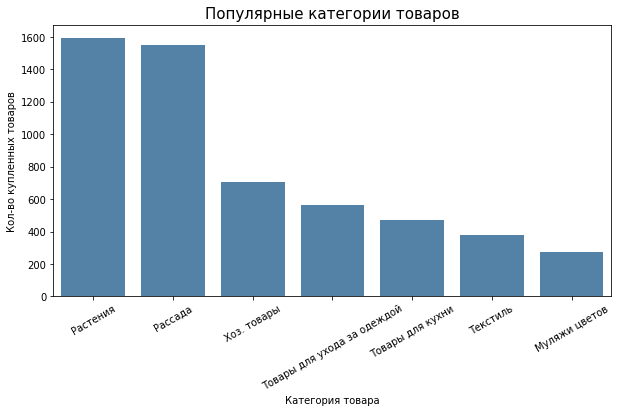

In [41]:
product = df.groupby('category', as_index = False)['product'].count().sort_values(by='product', ascending = False)
plt.figure(figsize=(10, 5))
sns.barplot(x='category', y='product', data=product, color='steelblue')
plt.title('Популярные категории товаров', fontsize=15)
plt.xlabel('Категория товара', fontsize=10)
plt.ylabel('Кол-во купленных товаров', fontsize=10)
plt.xticks(rotation=30);

Согласно  исследованию, чаще всего пользователи нашего интернет-магазина покупают растения и рассаду, а также разнообразные мелочи для дома, входящие в категорию хоз.товаров.

**Сезонность покупки категорий товаров по получившимся кластерам.**

In [42]:
print(df['date'].min(), df['date'].max())

2018-10-01 00:00:00 2020-01-31 15:00:00


В датасете, представленном клиентом, содержатся данные за неполные три года: начиная с октября 2018 года, заканчивая январем 2020.

In [43]:
#создадим столбец только с меясцем и годом покупки
df['month_year'] = df['date'].dt.strftime('%Y-%m')

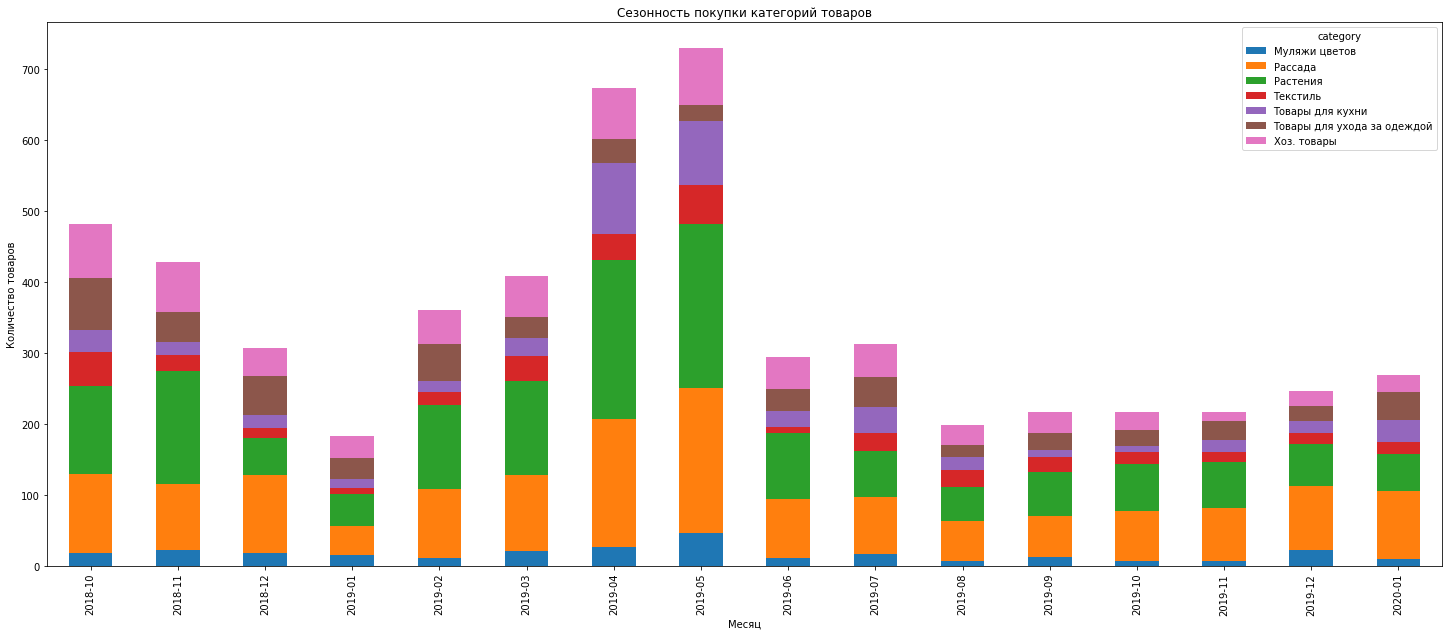

In [44]:
pivot_df = df.pivot_table(values='product', index='month_year', columns='category', aggfunc='count').sort_values(by='month_year')
(
    pivot_df
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

На основе общей картины можно сделать следующие выводы:
1. Пик покупки рассады приходится на май.
3. Растания также чаще всего покупают в апреле и мае.
4. Общая тенденция покупки товаров для дома заключается втом, что с января до мая включительно продажи постоянно растут и их пик приходится на май, в то время как начиная с июня продажи падают вдвое и колеблются на уровнях 200-300.

Ранее мы определили, что наиболее популярными категориями товаров являются растения, товары для кухни и рассада. Посмотрим их сезонность на основе кластеров профилей пользователей, также определенных ранее.

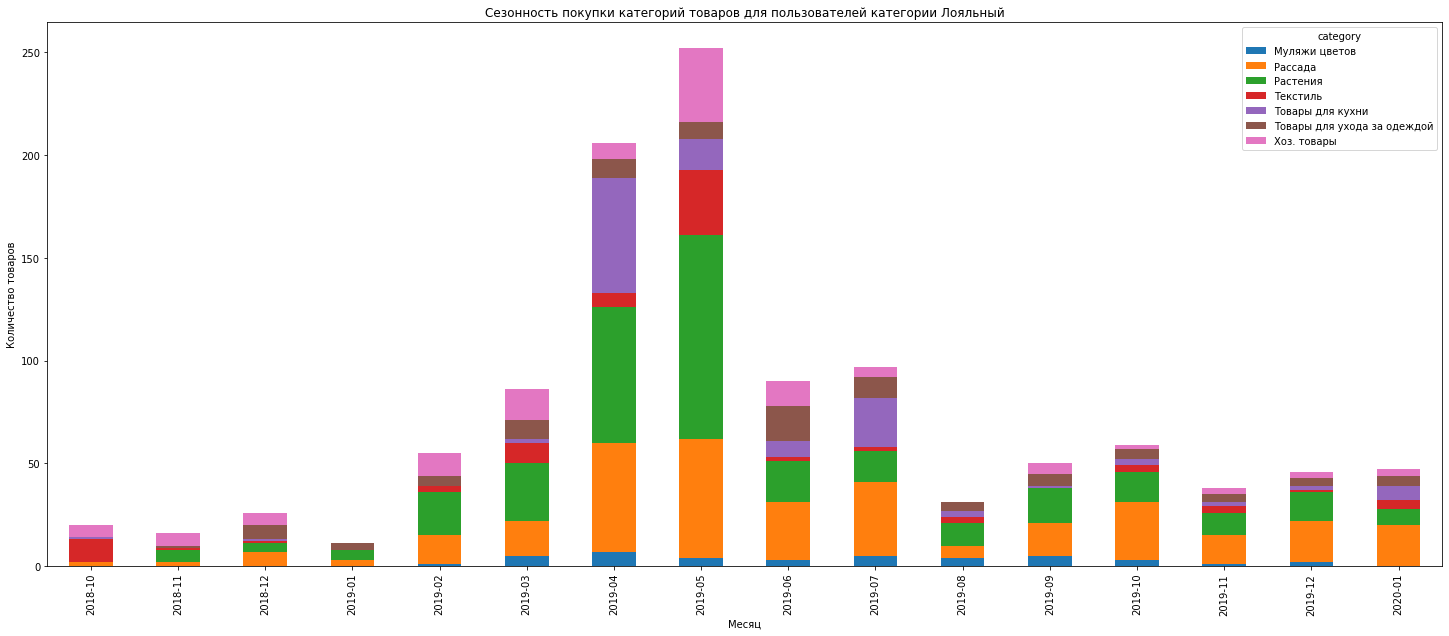

In [45]:
#проверяем пользователей категории Лояльный
top_cat = df[df['client_level'] == 'Лояльный']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Лояльный',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Итак, начинаем анализ популярных категорий товаров для категории пользователей Лояльные.
1. Наибольшее количество покупок совершается в апреле и мае. В это время покупается около сотни растений и сотни рассады в оба месяца.
2. Покупка хоз.товаров примерно одинакова на протяжении всего года, наибольший всплеск - в октябре.
3. В зимне-весенний период самые худшие результаты по покупкам.

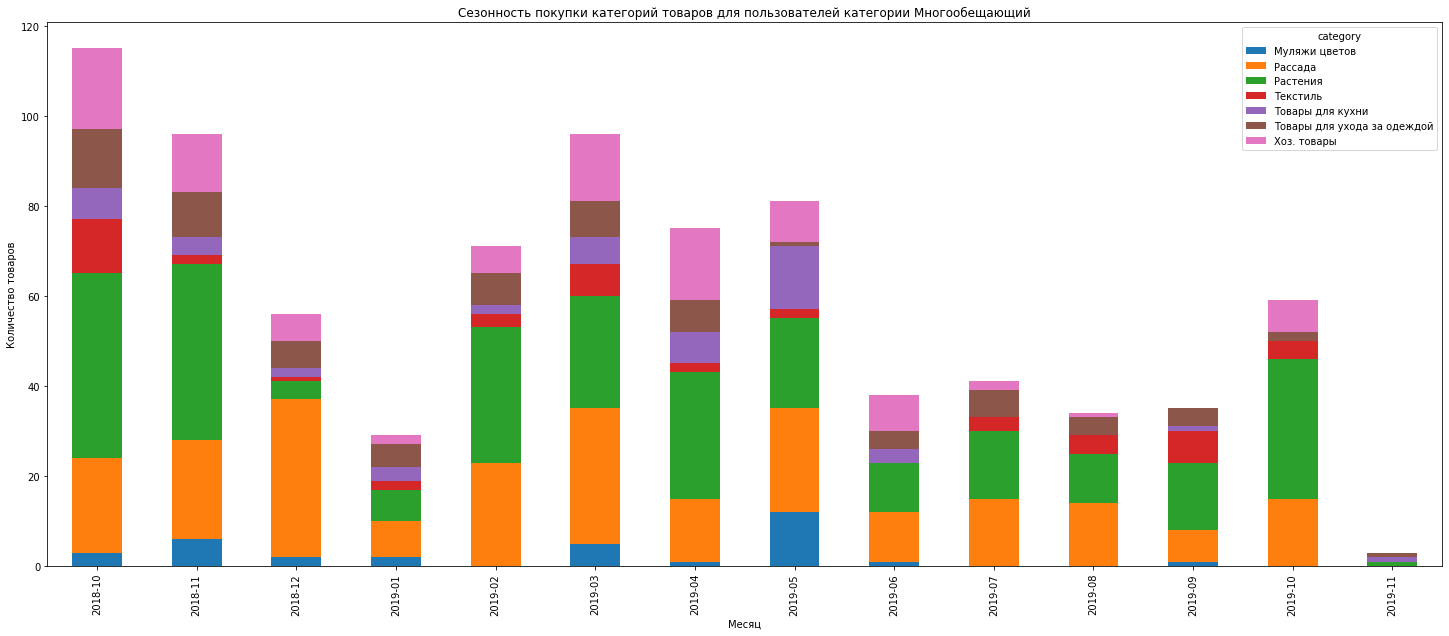

In [46]:
#проверяем пользователей категории Многообещающий
top_cat = df[df['client_level'] == 'Многообещающий']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Многообещающий',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Далее посмотрим на кластер пользователей Многообещающих:
1. В представленных данных информация только до октября 2019 года.
2. Пиковые значения приходятся на октябрь-ноябрь 2018 года и март 2019.
3. Растения активней всего покупаются в феврале, марте, апреле и октябре.
4. Наибольшее количество рассады куплено в мае.

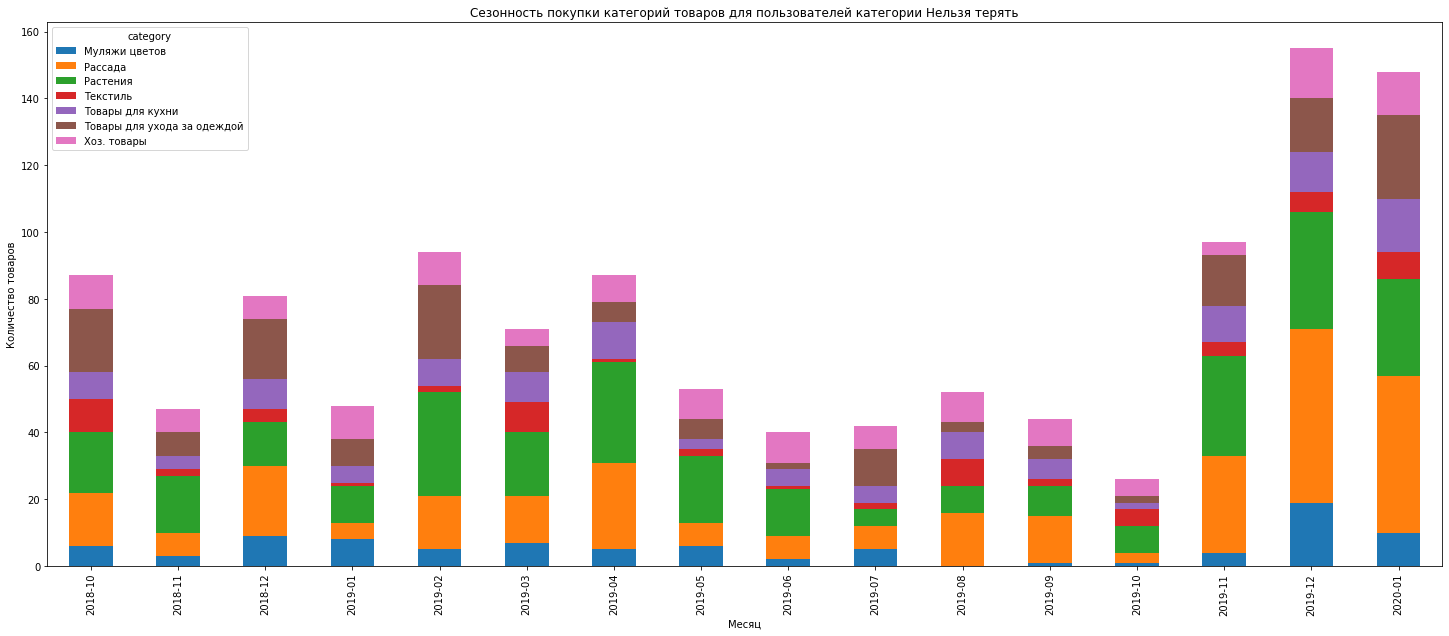

In [47]:
#проверяем пользователей категории Нельзя терять
top_cat = df[df['client_level'] == 'Нельзя терять']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Нельзя терять',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Выводы по кластеру Нельзя терять:
1. Всплеск покупок приходится на декабрь 2019, январь 2020 - в это же время чаще всего покупаются хоз.товары.
2. Расасду покупают только 6 месяцев в году - с апреля по июнь и в ноябре-январе.
3. Растения одинаково часто покупают как в мае-июне, так и в декабре-январе, но хуже всего - в октябре.

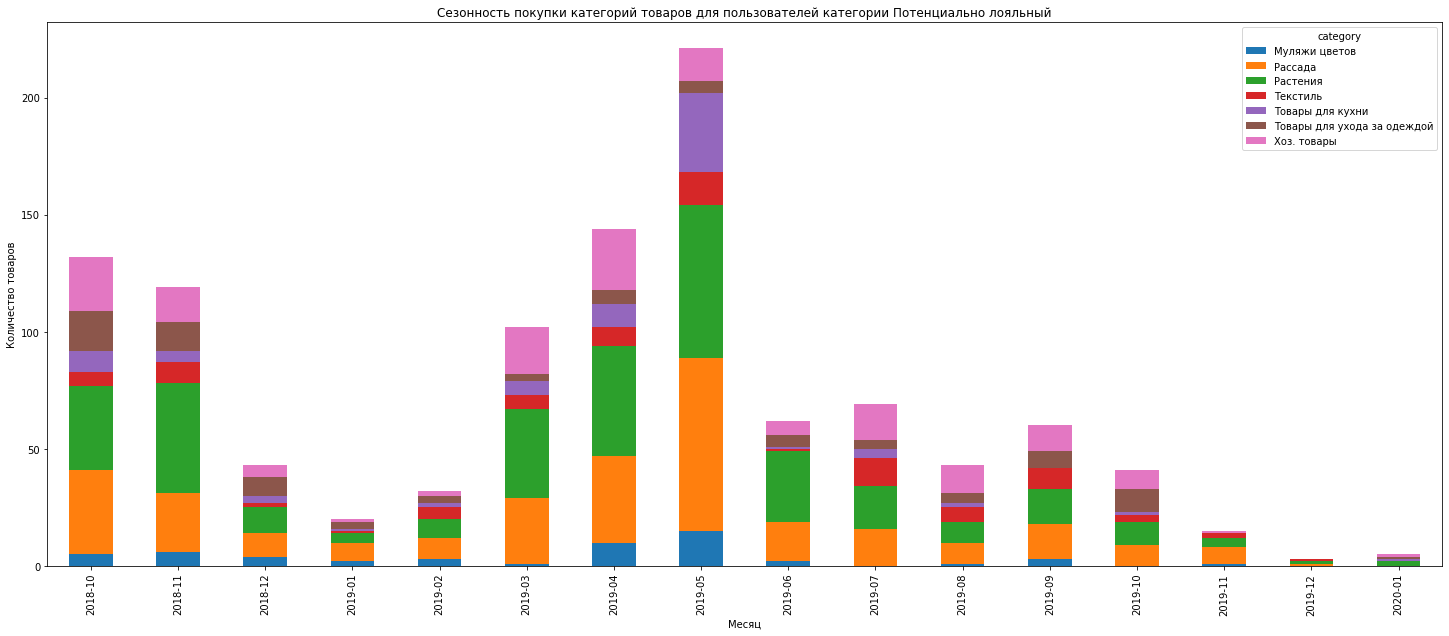

In [48]:
#проверяем пользователей категории Потенциально лояльный
top_cat = df[df['client_level'] == 'Потенциально лояльный']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Потенциально лояльный',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Кластер Потенциально лояльный:
1. В октябре-ноябре 2018 и с марта по май 2019 продажи намного выше остальных месяцев.
2. Самые малочисленные по количеству товаров месяцы - январь и декабрь.
3. В мае чаще других месяцев покупается рассада и растения.
4. В январе 2020 года почти не было покупок.

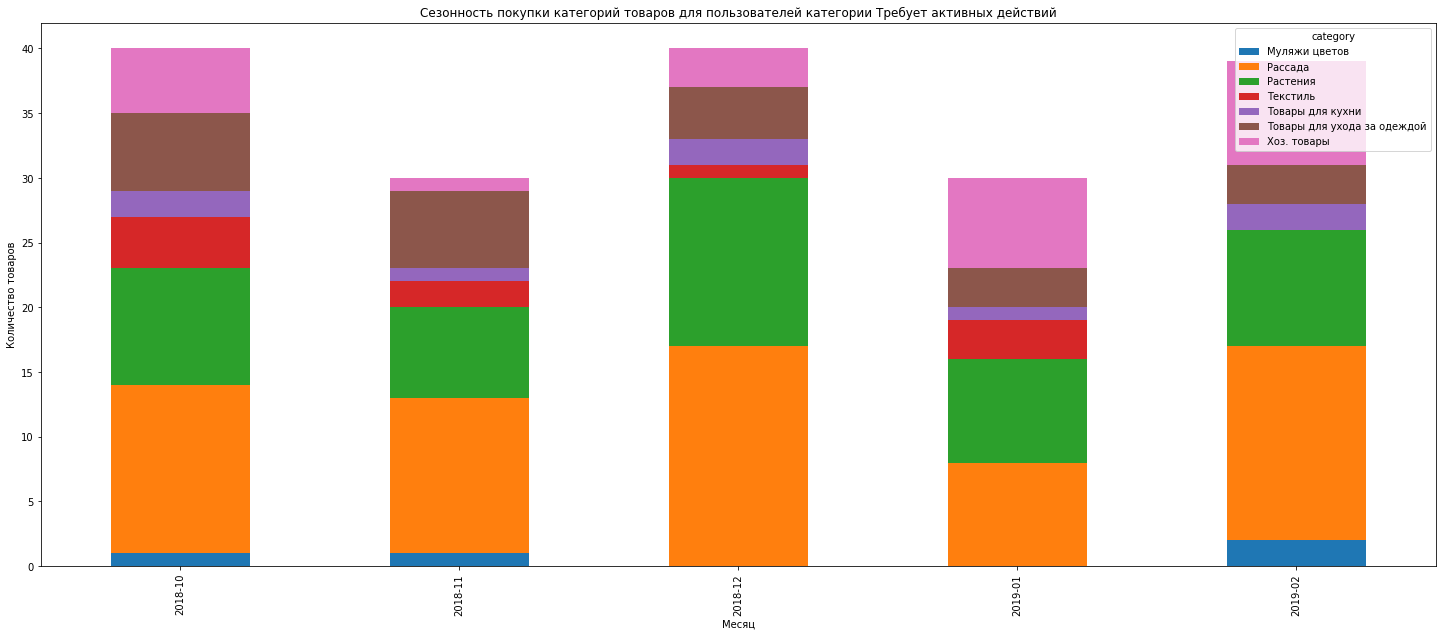

In [49]:
#проверяем пользователей категории Требует активных действий
top_cat = df[df['client_level'] == 'Требует активных действий']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Требует активных действий',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Сегмент "Требует активных действий" можно приравнять к потенциально потерянным клиентам:
1. Последние покупки были  в январе и феврале 2019 года.
2. В эти 2 месяца было куплено около 10 позиций растений (каждый месяц).

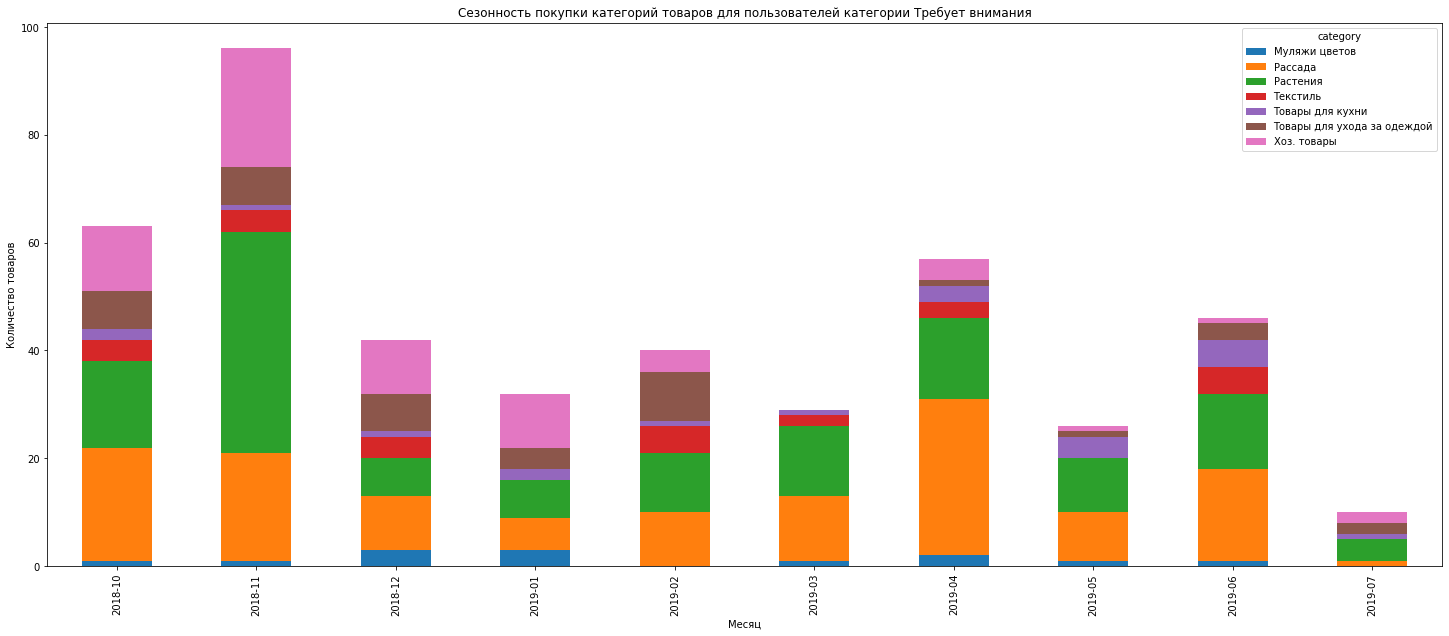

In [50]:
#проверяем пользователей категории Требует внимания
top_cat = df[df['client_level'] == 'Требует внимания']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Требует внимания',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Ситуация с пользователями, требующими внимания, лучше, чем с предыдущими, однако, последний заказ был сделан в июле:
1. С января по июнь 2019 количество купленных растений примерно одинаково.
2. Чаще всего рассада покупалась в феврале, апреле и июне.

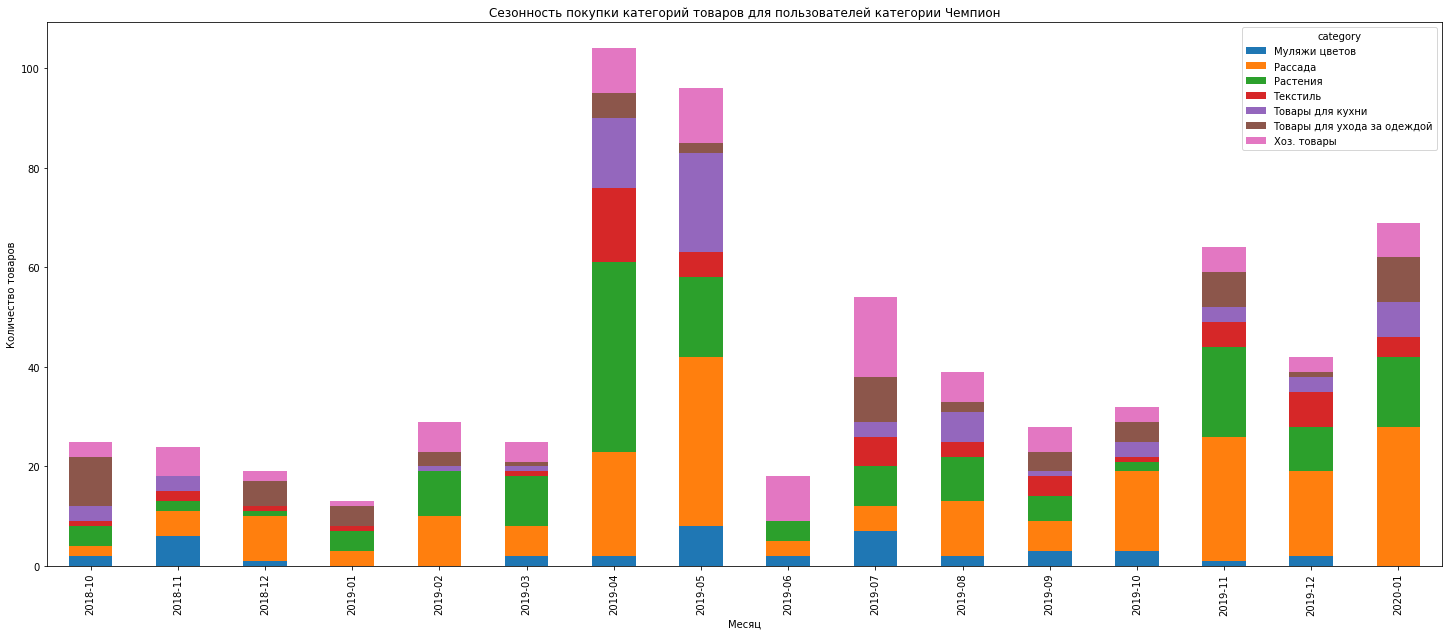

In [51]:
#проверяем пользователей категории Чемпион
top_cat = df[df['client_level'] == 'Чемпион']
top_cat = top_cat.pivot_table(values='product', index='month_year', columns='category', aggfunc='count')

(
    top_cat
    .plot
    .bar(
        stacked=True,
        figsize=(25, 10),
        title='Сезонность покупки категорий товаров для пользователей категории Чемпион',
        xlabel='Месяц',
        ylabel='Количество товаров'
    )
);

Чемпионы - одни из лучших клиенты:
1. Пик ихактивности приходится на апрель и май 2019 - в это время они активно закупаются рассадой и растениями.
2. Хоз. товары популярны среди этих пользователей в июле и ноябре.
3. Худшие показатели по продажам в январе 2019 и июне 2019.

### Проверка гипотез.

**Первая стат. гипотеза:**
  - Н0 - Нет различий в величине среднего чека между кластерами, сформированными профилями потребления.
  - Н1 - Различия в величине среднего чека между кластерами, сформированными профилями потребления, есть.

In [52]:
#следует определить уровень стат.значимости, используя метод Шидака
#всего у нас может быть 21 сравнение 7 кластеров
alpha = 0.05 # изначальный уровень статистической значимости

alpha = 1 - (1 - 0.05)**(1/21) #уровень значимости для проверки наших гипотез

In [53]:
#проверим все получившиеся кластеры между собой
category1 = df[df['client_level'] == 'Нельзя терять'].groupby('order_id')['total'].sum()
category2 = df[df['client_level'] == 'Чемпион'].groupby('order_id')['total'].sum()
category3 = df[df['client_level'] == 'Лояльный'].groupby('order_id')['total'].sum()
category4 = df[df['client_level'] == 'Потенциально лояльный'].groupby('order_id')['total'].sum()
category5 = df[df['client_level'] == 'Многообещающий'].groupby('order_id')['total'].sum()
category6 = df[df['client_level'] == 'Требует внимания'].groupby('order_id')['total'].sum()
category7 = df[df['client_level'] == 'Требует активных действий'].groupby('order_id')['total'].sum()

categories = [category1, category2, category3, category4, category5, category6, category7]
names = ['Нельзя терять', 'Чемпион', 'Лояльный', 'Потенциально лояльный', 'Многообещающий', 'Требует внимания', 'Требует активных действий']

p_values = []
for col_name1 in range(len(categories)):
    for col_name2 in range(col_name1+1, len(categories)):
        statistic, p_value = st.mannwhitneyu(categories[col_name1], categories[col_name2])
        p_values.append(p_value)
        
for i in p_values:
    if i < alpha:
        print('По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print('По результатам теста Манна-Уитни не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 


По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отверг

17 из 21 теста показали, что разница между кластерами статистически значима. Таким образом, больше 80% теста говорит о том, что кластеры разделены корректно.

**Вторая стат. гипотеза:**
  - Н0 - Нет различий в количестве товарных единиц в заказах между кластерами, сформированными профилями потребления.
  - Н1 - Различия в количестве товарных единиц в заказах между кластерами, сформированными профилями потребления, есть.

In [54]:
#проверим все получившиеся кластеры между собой
category1 = df[df['client_level'] == 'Нельзя терять'].groupby('order_id')['quantity'].sum()
category2 = df[df['client_level'] == 'Чемпион'].groupby('order_id')['quantity'].sum()
category3 = df[df['client_level'] == 'Лояльный'].groupby('order_id')['quantity'].sum()
category4 = df[df['client_level'] == 'Потенциально лояльный'].groupby('order_id')['quantity'].sum()
category5 = df[df['client_level'] == 'Многообещающий'].groupby('order_id')['quantity'].sum()
category6 = df[df['client_level'] == 'Требует внимания'].groupby('order_id')['quantity'].sum()
category7 = df[df['client_level'] == 'Требует активных действий'].groupby('order_id')['quantity'].sum()

categories = [category1, category2, category3, category4, category5, category6, category7]
names = ['Нельзя терять', 'Чемпион', 'Лояльный', 'Потенциально лояльный', 'Многообещающий', 'Требует внимания', 'Требует активных действий']

p_values = []
for col_name1 in range(len(categories)):
    for col_name2 in range(col_name1+1, len(categories)):
        statistic, p_value = st.mannwhitneyu(categories[col_name1], categories[col_name2])
        p_values.append(p_value)
        
for i in p_values:
    if i < alpha:
        print('По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима')
    else:
        print('По результатам теста Манна-Уитни не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 



По результатам теста Манна-Уитни не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница статистически значима
По результатам теста Манна-Уитни отвергаем нулевую гипотезу: разница стат

По результатам стат.анализа кластеров 14 из 21 показал, что разница статистически значима - это более 66%.

### Итоговый вывод.

Целью настоящего ислледования было выявление профилей потребления, определения в соответствии с созданными кластерами популярных товаров и отслеживание их сезонности.

Для решения поставленной задачи был проанализирован датасет, содержащий 5607 событий, в которых содержится информация по 2450 уникальным клиентам и 3519 уникальным заказам.

Согласно проведенной сегментации всех клиентов разделены следующим образом:
1. **Нельзя терять**: 438 пользователей. Они покупали недеавно, покупают часто и больше всех. 
    - Для удержания таких клиентов, согласно проведенному анализу, следует награждать их и сделать из них фокус группу для нового продукта: в начинающимся 2020 году активно покупают абсолютно все категории товаров. Однако, следует обратить внимание на тенденции 2019 года - к апрелю и маю спрос на рассаду повысился, второй по популярности категорией товаров были растения.
2. **Чемпионы**: 296 пользователей. Делают частые покупки на крупные суммы, хорошо реагируют на рекламу. 
    - Для таких клиентов следует также таргетировать рекламу, в частности, рекламу растений и рассады. Так как результаты января 2020 года лучше, чем января 2019, следует предлагать более дорогие позиции из-за их повышенной лояльности и по той же причине оставлять отзывы в социальных сетях и интернете.
3. **Лояльные**: 369 пользователей. Уровень давности чуть выше среднего, частота и сумма покупок на среднем уровне. 
    - Можно предлагать ограниченные по времени оферы. Рекомендовать товары на основе прошлых покупок. Стоит учитывать данные за 2019 год и их повышенный спрос в отношении растений и рассады. Также эти клиенты на протяжении всего времени в одинаковом количестве покупают хоз.товары.
4. **Потенциально лояльные**: 417 пользователей. Близки к лояльным, однако, уровень давности немного выше, а частота ниже.
    - Нет данных о покупках за декабрь 2019 года вообще, в январе 2020 покупки на крайне низких отметках. Чтобы не упустить пользователей и сделать из них лояльных, требуется их реактивировать - предлагать уникальные акции и бесплатные пробники. Согласно данным, в прошлом году больше всего их интересовали растения, рассада и хоз. товары.
5. **Многообещающий**: 469 пользователей. Покупали примерно так же давно, как и потенциально лояльные, но не на крупные суммы.
    - Пользователи не совершали покупок с октября 2019 года, но до этого времени у них пользовались популярностью растения и хоз. товары. Следует их "разбудить" путем скидок и промокодов, тем самым увеличив уровень их покупательской способности.
6. **Требующий внимания**: 313 пользователей. Ранее совершали покупки, но давно не появлявшиеся.
    - Последняя покупка была почти год назад. Возможно, стоит отправлять персонализированные имейлы, чтобы возобновить связь с клиентом, предлагать попробовать товар еще раз, предоставить полезную информацию. Лучше всего в имейлах предоставлять информацию по растениям - наиболее популярные товары на протяжении всей жизни данного кластера пользователей.
7. **Требующие активных действий**: 148 пользователей. Последняя покупка была очень давно. Также низкие чек и количество покупок.
    - В качестве рекомендаций можно также на основе предыдущих покупок предложить пользователям специальные скидки и предложения. Однако, последняя покупка была в феврая 2019 года, было куплено немного товаров и на маленький чек. По этой причине, следует оценить, насколько затратно рассылать персонализированные имейлы этому кластеру в соответствии с потенциальной выручкой.